In [4]:
%cd /content/drive/My\ Drive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET

/content/drive/My Drive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET


# **Extract file and load data**

Download here: [http://yanweifu.github.io/FG_NET_data/FGNET.zip](http://yanweifu.github.io/FG_NET_data/FGNET.zip)

In [0]:
import os
import zipfile

local_zip = 'FGNET.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content/drive/My Drive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET')
zip_ref.close()

In [5]:
import os
data_dir = 'FGNET/images'

files = os.listdir(data_dir)

print(len(files))

1003


In [0]:
import numpy as np
ages = []
for imageName in files:
  age = imageName[imageName.find('A') + 1: imageName.find('A') + 1 + 2]
  # print(age)
  ages.append(int(age))

linkImage = {str(key): [] for key in ages}
for imageName in files:
  age = imageName[imageName.find('A') + 1: imageName.find('A') + 1 + 2]
  if int(age) >= 20:
    linkImage[str(age)].append(imageName)

ages = np.array(ages)
print(linkImage['21'])


['067A21.JPG', '072A21.JPG', '082A21.JPG', '008A21.JPG', '012A21.JPG', '013A21.JPG', '023A21.JPG', '033A21.JPG', '034A21.JPG', '035A21.JPG', '038A21.JPG', '040A21.JPG', '041A21.JPG', '044A21.JPG', '002A21.JPG', '004A21.JPG']


In [0]:
len(ages)

1002

# **Perform Data Exploration**

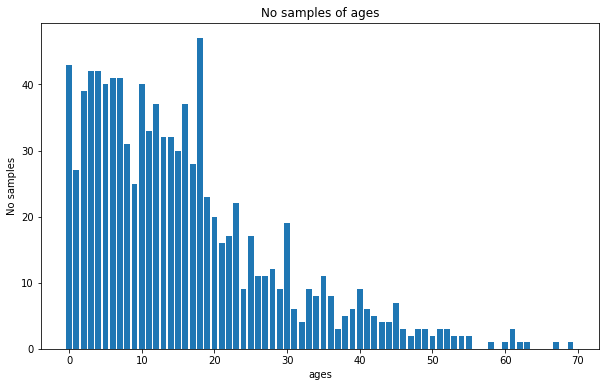

In [0]:
import matplotlib.pyplot as plt

def _plot_bar(varname):
  labels, values = np.unique(ages, return_counts=True)
  plt.figure(figsize=(10, 6))
  ax = plt.subplot()
  ax.bar(x=labels, height=values)
  ax.set_title('No samples of ' + varname)
  ax.set_xlabel(varname)
  ax.set_ylabel('No samples')
  plt.show()

_plot_bar('ages')

In [0]:
import pandas as pd

labels, values = np.unique(ages, return_counts=True)
age_df = pd.DataFrame(data = values, index = labels, columns = ['Freq'])

age_df

,Freq
0,43
1,27
2,39
3,42
4,42
...,...
61,3
62,1
63,1
67,1


In [0]:
age_df.describe()

,Freq
count,63.000000
mean,15.904762
std,14.765603
min,1.000000
25%,3.000000
50%,9.000000
75%,29.000000
max,47.000000


In [0]:
age_df.loc[age_df.idxmax()]

,Freq
18,47


In [0]:
age_df.loc[age_df.idxmin()]

,Freq
58,1


In [0]:
age_lst = list(age_df.index.values)

In [0]:
#Find missing ages
miss_ages = []
for age in range(70):
  if age not in age_lst:
    miss_ages.append(age)

miss_ages

[56, 57, 59, 64, 65, 66, 68]

In [0]:
import numpy as np
from PIL import Image
import progressbar   

widgets = ['Reading images:',progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(maxval = len(files), widgets = widgets).start()

images = []
ages = []
for i, imageData in enumerate(files):
  age = imageData[imageData.find('A') + 1: imageData.find('A') + 1 + 2]
  image = np.array(Image.open(data_dir + '/' + imageData).convert('RGB').resize((224, 224)))
  if int(age) >= 20:
    images.append(image)
    ages.append(int(age))
    images.append(image)
    ages.append(int(age))
  else:
    images.append(image)
    ages.append(int(age))
  pbar.update(i)

pbar.finish()

images = np.array(images)

Reading images:100% |##########################################| Time:  0:09:19


In [0]:
len(images)

1294

In [0]:
len(ages)

1294

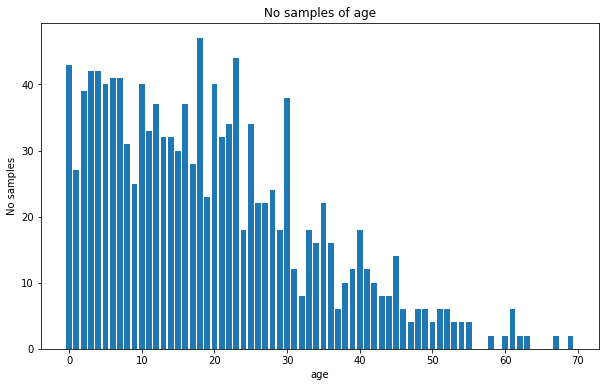

In [0]:
_plot_bar('age')

In [0]:
 ages = np.array(ages)

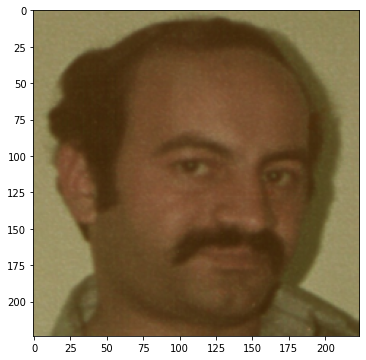

In [0]:
from matplotlib import image

plt.figure(figsize = (6, 6))
plt.imshow(images[10])
plt.show()

In [0]:
print(ages[10])

28


In [0]:
images[0].shape

(224, 224, 3)

In [0]:
import matplotlib
def displayImage(startIdx, numImages, imagePath, showAge = True):
  endIdx = startIdx + numImages
  size = (5,5)
  fig = plt.figure(figsize = (3*numImages, 2*numImages))
  listImage = os.listdir(imagePath)
  for i, imagename in enumerate(listImage[startIdx : endIdx]):
    ax = fig.add_subplot(size[0], size[1], i + 1, xticks = [], yticks = [])
    img = matplotlib.image.imread(imagePath + '/' + imagename)
    ax.imshow(img)
    if showAge:
      ax.set_title('Imagename: {}, Age: {}'.format(imagename, ages[startIdx + i]), color = 'green')

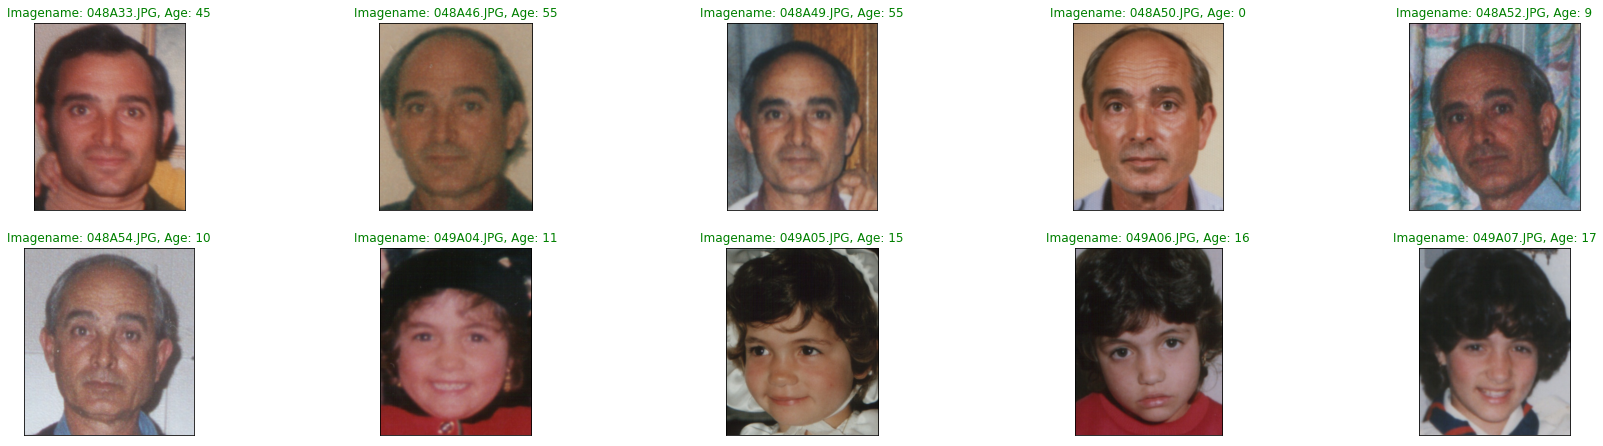

In [0]:
displayImage(50, 10, 'FGNET/images')

**Split data in training set and validation set**

In [0]:
from sklearn.model_selection import train_test_split

images = images.astype('float')/255

(trainData, testData, trainLabels, testLabels) = train_test_split(images, ages, test_size = 0.2, random_state = 42, shuffle =True)

**Create Dataset with tf.data.Dataset**

In [0]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((trainData, trainLabels))
test_dataset = tf.data.Dataset.from_tensor_slices((testData, testLabels))

# **Perform Data Augmentation**

In [0]:
def augment(image,label, mode):
  if mode == 'train':
      # image = tf.image.resize_with_crop_or_pad(image, 230, 230) # Add 6 pixels of padding
      image = tf.image.random_crop(image, size=[218, 218, 3])
      image = tf.image.resize(image, size=[224, 224])
      image = tf.image.random_saturation(image, 2, 3)
      image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
      image = tf.image.random_flip_left_right(image)
      return image,label
  else:
      image_cropped = tf.image.crop_to_bounding_box(image, offset_height=20, offset_width=0, target_height=200, target_width=224)
      image_resized = tf.image.resize(image_cropped, size= [224,224])
      return image_resized, label

In [0]:
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_TEST = 16
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).map(lambda image, label: augment(image, label, mode = 'train'), num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE_TRAIN)
test_dataset = test_dataset.map(lambda image, label: augment(image, label, mode = 'eval'), num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE_TEST)

# **BUILDING MODEL BASE ON RESNET 34 ARCHITECTURE**

In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, BatchNormalization, ZeroPadding2D, Add, Input, AveragePooling2D, GlobalMaxPooling2D, Lambda, Dropout
from tensorflow.keras.initializers import glorot_uniform
import tensorflow as tf

In [0]:
def identity_block(X, f, filters, stage, block):
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2 = filters

  X_shortcut = X

  X = Conv2D(filters = F1, kernel_size= (f,f), strides= (1,1), padding= 'same', name = conv_name_base + '2a', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters = F2, kernel_size= (f,f), strides= (1,1), padding= 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = -1, name = bn_name_base + '2b')(X)

  X = Add()([X_shortcut, X])
  X = Activation('relu')(X)

  return X

In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
  conv_name_base = 'res' + str(stage) + block + '_branch'
  bn_name_base = 'bn' + str(stage) + block + '_branch'

  F1, F2 = filters

  X_shortcut = X

  X = Conv2D(filters = F1, kernel_size= (f,f), strides= (s,s), padding= 'same', name = conv_name_base + '2a', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = -1, name = bn_name_base + '2a')(X)
  X = Activation('relu')(X)

  X = Conv2D(filters = F2, kernel_size= (f,f), strides= (1,1), padding= 'same', name = conv_name_base + '2b', kernel_initializer=glorot_uniform(seed = 0))(X)
  X = BatchNormalization(axis = -1, name = bn_name_base + '2b')(X)

  X_shortcut = Conv2D(filters = F2, kernel_size=(1,1), strides = (s,s), name = conv_name_base + '1', kernel_initializer=glorot_uniform(seed = 0))(X_shortcut)
  X_shortcut = BatchNormalization(axis = -1, name = bn_name_base + '1')(X_shortcut)

  X = Add()([X_shortcut, X])
  X = Activation('relu')(X)

  return X

In [0]:
def ResNet_34Base(input_shape, classes, activation = 'softmax'):
  X_input = Input(input_shape)

  X = ZeroPadding2D((3,3))(X_input)

  #Stage 1
  X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
  X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
  X = Activation('relu')(X)
  X = MaxPooling2D((3, 3), strides=(2, 2))(X)

  #Stage 2
  X = convolutional_block(X, f = 3, filters = [64, 64], stage = 2, block = 'a', s = 1)
  X = identity_block(X, f = 3, filters= [64, 64], stage = 2, block = 'b')
  X = identity_block(X, f = 3, filters= [64, 64], stage = 2, block = 'c')

  #Stage 3
  X = convolutional_block(X, f = 3, filters = [128, 128], stage = 3, block = 'a', s = 2)
  X = identity_block(X, f = 3, filters= [128, 128], stage = 3, block = 'b')
  X = identity_block(X, f = 3, filters= [128, 128], stage = 3, block = 'c')
  X = identity_block(X, f = 3, filters= [128, 128], stage = 3, block = 'd')

  #Stage 4
  X = convolutional_block(X, f = 3, filters = [256, 256], stage = 4, block = 'a', s = 2)
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'b')
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'c')
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'd')
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'e')
  X = identity_block(X, f = 3, filters= [256, 256], stage = 4, block = 'f')

  #Stage 5
  X = convolutional_block(X, f = 3, filters = [512, 512], stage = 5, block = 'a', s = 2)
  X = identity_block(X, f = 3, filters= [512, 512], stage = 5, block = 'b')
  X = identity_block(X, f = 3, filters= [512, 512], stage = 5, block = 'c')

  X = AveragePooling2D(pool_size=(2,2), name = 'avg_pool')(X)

  X = Flatten()(X)
  X = Dense(classes, activation= 'softmax', name = 'fc' + str(classes), kernel_initializer=glorot_uniform(seed = 0))(X)

  model = Model(inputs = X_input, outputs = X, name = 'age_resnet_34')
  return model

In [0]:
model = ResNet_34Base((224, 224, 3), 70)

In [0]:
model.summary()

**Model Architecture**

In [0]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file = 'Resnet34Base.png', show_shapes = True)

# **USE PRETRAINED MODEL APPROACH**

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

load_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pretrained_model = InceptionV3(input_shape = (224, 224, 3), include_top = False, weights = None)

pretrained_model.load_weights(load_weights_file)

for layer in pretrained_model.layers:
  layer.trainable = False

pretrained_model.summary()

--2020-05-15 14:18:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 2607:f8b0:4001:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   214MB/s    in 0.4s    

2020-05-15 14:18:49 (214 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                             

In [0]:
layer_output = pretrained_model.get_layer('mixed7')
last_output = layer_output.output

In [0]:
# Flatten the output layer to 1 dimension
x = Flatten()(last_output)
x = Dropout(0.25)(x)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.5)(x)                  
# Add a final sigmoid layer for classification
x = Dense  (70, activation='softmax')(x) 

model = Model(pretrained_model.input, x)

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 111, 111, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 111, 111, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 111, 111, 32) 0           batch_normalization_94[0][0]     
______________________________________________________________________________________________

## **CREATE CUSTOM LOSS FUNCTION BASE ON RESEARCH PAPER**
[On this link](http://openaccess.thecvf.com/content_cvpr_2018/papers/Pan_Mean-Variance_Loss_for_CVPR_2018_paper.pdf)

In [0]:
def mean(p_i):
  mean = 0
  # print('y_pred_i', y_pred_i)
  # print('Shape', tf.shape(y_pred_i))
  # for j in range(tf.shape(y_pred_i).numpy().shape[1]):
  for j in range(len(p_i)):
    mean += p_i[j]*(j+1)
  return mean

In [0]:
def variance(p_i):
  variance = 0
  # print('y_pred_i',y_pred_i)
  # for j in range(tf.shape(y_pred_i).numpy().shape[1]):
  for j in range(len(p_i)):
    variance += p_i[j]*((j+1) - mean(p_i))**2
  return variance

In [0]:
def mean_loss(y_true, p_pred):
  # print('y_pred', y_pred)
  # print('y_true', y_true)
  # print('Shape', p_pred.numpy().shape)
  m_tensor = tf.constant([mean(i) for i in p_pred.numpy()], dtype = 'float32')
  squared_difference = tf.square(tf.cast(y_true, dtype = 'float32') - m_tensor)
  return (1/2)*tf.reduce_mean(squared_difference, axis=-1)

In [0]:
def variance_loss(y_true, p_pred):
  total_variance = 0
  # for i in range(tf.shape(y_pred_i).numpy().shape[1]):
  # print(p_pred.numpy().shape)
  for i in range(p_pred.numpy().shape[0]):
    total_variance += variance(p_pred.numpy()[i])
  return (1/p_pred.numpy().shape[0])*total_variance

In [0]:
def loss(model, x, y_true, lambda1, lambda2, training):
  p_pred = model(x, training=training)
  # y_pred = tf.constant([mean(i) for i in p_pred.numpy()], dtype = 'float32')
  # print(y_pred)
  softmax_Loss = tf.keras.losses.SparseCategoricalCrossentropy()
  return softmax_Loss(y_true, p_pred) + lambda1*mean_loss(y_true, p_pred) + lambda2*variance_loss(y_true, p_pred)

In [0]:
INIT_LEARNING_RATE = 0.001
EPOCHS = 100
LAMBDA_1 = 0.2
LAMBDA_2 = 0.05

In [0]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=INIT_LEARNING_RATE,
    decay_steps=200,
    decay_rate=0.1,
    staircase = True
)

In [0]:
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)

In [0]:
def grad(model, inputs, targets, lambda1, lambda2):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, lambda1, lambda2, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [0]:
import progressbar

def train(train_set, test_set, model, h_para = {}):
  train_loss_results = []
  train_mae_results = []
  test_loss_results = []
  test_mae_results = []

  num_epochs, lambda1, lambda2 = h_para['epochs'], h_para['l_1'], h_para['l_2']

  # widgets = ['Epochs: ', progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
  # pbar = progressbar.ProgressBar(maxval = 1000, widgets = widgets).start()

  for epoch in range(num_epochs):
    epoch_train_loss_avg = tf.keras.metrics.Mean()
    epoch_train_mae = tf.keras.metrics.MeanAbsoluteError()
    epoch_test_loss_avg = tf.keras.metrics.Mean()
    epoch_test_mae = tf.keras.metrics.MeanAbsoluteError()

    # Training loop - using batches of 64
    for count, (x, y) in enumerate(train_set):
      #Calculate loss value and update weight
      loss_value, grads = grad(model, x, y, lambda1, lambda2)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

      # Track progress
      epoch_train_loss_avg.update_state(loss_value)  # Add current batch loss

      # Compare predicted label to actual label
      # training=True is needed only if there are layers with different
      # behavior during training versus inference (e.g. Dropout).
      
      probs = model(x, training=True)
      y_hat = tf.constant([mean(i) for i in probs.numpy()], dtype = 'float32')
      y_hat = tf.round(y_hat)
      epoch_train_mae.update_state(y, y_hat)

      # pbar.update(count)

    train_loss_results.append(epoch_train_loss_avg.result())
    train_mae_results.append(epoch_train_mae.result())


    #Validation loop batch size 16
    for test_x, test_y in test_set:
      test_loss_value, _ = grad(model, test_x, test_y, lambda1, lambda2)
      epoch_test_loss_avg.update_state(test_loss_value)
      
      test_probs = model(test_x, training=False)
      test_y_hat = tf.constant([mean(i) for i in test_probs.numpy()], dtype = 'float32')
      test_y_hat = tf.round(test_y_hat)
      epoch_test_mae.update_state(test_y, test_y_hat)

    test_loss_results.append(epoch_test_loss_avg.result())
    test_mae_results.append(epoch_test_mae.result())

    if epoch % 5 == 0:
      print("\nEpoch {:03d}: Loss: {:.3f}, MAE: {:3f}, Val_loss : {:.3f}, Val_MAE: {:3f}".format(epoch,
                                                                  epoch_train_loss_avg.result(),
                                                                  epoch_train_mae.result(),
                                                                  epoch_test_loss_avg.result(),
                                                                  epoch_test_mae.result()))
      
  # pbar.finish()

  history = {'Loss':train_loss_results, 'MAE': train_mae_results, 'Val_loss':test_loss_results, 'Val_MAE':test_mae_results}

  return history

In [0]:
h_para = {'epochs':EPOCHS, 'l_1': LAMBDA_1, 'l_2' : LAMBDA_2}

history = train(train_dataset, test_dataset, model, h_para)


Epoch 000: Loss: 52.019, MAE: 13.957135, Val_loss : 42.382, Val_MAE: 12.425245

Epoch 005: Loss: 29.616, MAE: 9.799966, Val_loss : 32.736, Val_MAE: 10.268382

Epoch 010: Loss: 21.462, MAE: 7.955548, Val_loss : 26.599, Val_MAE: 8.689951

Epoch 015: Loss: 19.162, MAE: 7.116895, Val_loss : 25.672, Val_MAE: 8.492647

Epoch 020: Loss: 17.941, MAE: 6.905080, Val_loss : 25.453, Val_MAE: 8.355392

Epoch 025: Loss: 18.050, MAE: 7.011029, Val_loss : 24.498, Val_MAE: 8.341911

Epoch 030: Loss: 17.539, MAE: 6.773229, Val_loss : 24.383, Val_MAE: 8.337010

Epoch 035: Loss: 18.289, MAE: 7.102356, Val_loss : 24.399, Val_MAE: 8.318627

Epoch 040: Loss: 17.836, MAE: 6.880932, Val_loss : 24.598, Val_MAE: 8.307598

Epoch 045: Loss: 18.141, MAE: 6.918282, Val_loss : 24.504, Val_MAE: 8.311275


In [0]:
model.save('FGNET/images/Age_Model.h5')

In [0]:
import matplotlib.pyplot as plt

def plot_history(history):

  fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
  fig.suptitle('Training Metrics')
  epochs = 20

  axes[0].set_xlabel("Epochs", fontsize=14)
  axes[0].set_ylabel("Loss", fontsize=14)
  axes[0].plot(history['Loss'], 'b')
  axes[0].plot(history['Val_loss'], 'r')

  axes[1].set_xlabel("Epochs", fontsize=14)
  axes[1].set_ylabel("MAE", fontsize=14)
  axes[1].plot(history['MAE'], 'b')
  axes[1].plot(history['Val_MAE'], 'r')
  plt.show()

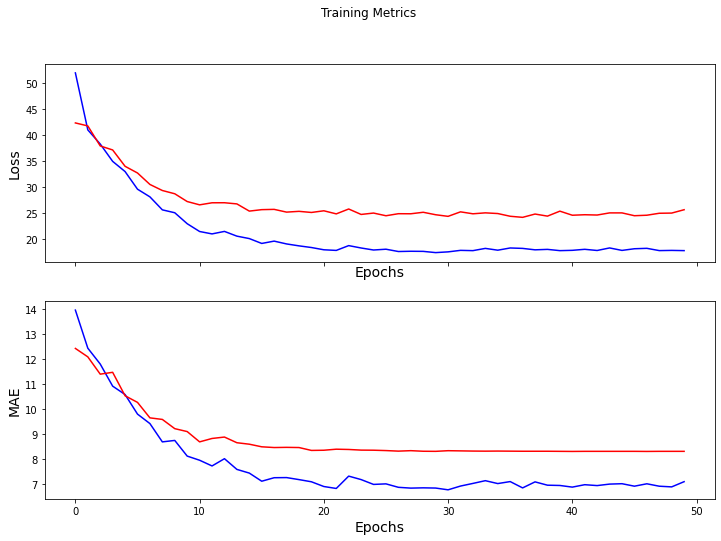

In [0]:
plot_history(history)

## **TESTING**

In [0]:
from tensorflow.keras.models import load_model

test_image = testData[200]
test_image = tf.constant(test_image, dtype = 'float32')
test_image = tf.expand_dims(test_image, axis = 0)
model = load_model('/FGNET/images/Age_Model.h5')
prediction = model(test_image)

In [0]:
prediction

<tf.Tensor: shape=(1, 70), dtype=float32, numpy=
array([[0.03283162, 0.01141991, 0.00890172, 0.00674907, 0.01391594,
        0.04045115, 0.0238151 , 0.03423969, 0.04501638, 0.01894217,
        0.04582387, 0.02466102, 0.00905101, 0.01927598, 0.03886402,
        0.03485585, 0.02468161, 0.02119601, 0.05465097, 0.02032841,
        0.01894617, 0.02627353, 0.00387196, 0.01060027, 0.00598812,
        0.01102387, 0.00593284, 0.00877145, 0.01639363, 0.02136154,
        0.0712211 , 0.01421723, 0.00465933, 0.01421119, 0.01863196,
        0.00934573, 0.03626454, 0.00177512, 0.00508625, 0.00867137,
        0.00833339, 0.02791987, 0.0040859 , 0.00646081, 0.00894248,
        0.01144286, 0.01410004, 0.00337447, 0.00471216, 0.00274189,
        0.00550167, 0.00198879, 0.00313362, 0.00971649, 0.00402107,
        0.00160506, 0.00203245, 0.00207523, 0.00206117, 0.00426523,
        0.00124935, 0.00560074, 0.00157653, 0.00432587, 0.00212601,
        0.00202321, 0.0029477 , 0.00206358, 0.00293084, 0.00372282]

In [0]:
prediction = tf.argmax(prediction, axis = 1, output_type=tf.int32)
prediction

<tf.Tensor: shape=(1,), dtype=int32, numpy=array([30], dtype=int32)>

In [0]:
age_pred = int(prediction.numpy())
print('Prediction', age_pred)

Prediction 30


In [0]:
age_true = int(testLabels[200])
print('Ground true', age_true)

Ground true 9


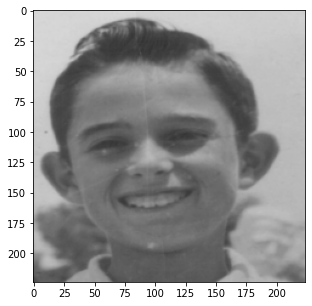

In [0]:
plt.figure(figsize=(5,5))
plt.imshow(testData[200])
plt.show()

**LET'S LOAD SOME IMAGES AND TEST**

*Note that because data was trained on white people dataset so the prediction may not obtain a good result on none-white people*

**Here we just need to use a pretrained face detector to detect ROI of a face in an image**

In [0]:
import cv2

In [6]:
print("[INFO] loading face detector model...")
prototxtPath = os.path.sep.join(["FGNET/face_detector", "deploy.prototxt"])
weightsPath = os.path.sep.join(["FGNET/face_detector",
	"res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

[INFO] loading face detector model...


Saving human-613601_640.jpg to human-613601_640 (2).jpg
Saving phu.jpg to phu (5).jpg
Saving person-1284444_640.jpg to person-1284444_640 (3).jpg
Saving gt.jpg to gt (12).jpg
[INFO] computing face detections...
tf.Tensor(
[[0.02630946 0.00486782 0.01236013 0.01328819 0.01979056 0.01869846
  0.02166635 0.02170066 0.00572031 0.01235537 0.03496138 0.01205323
  0.01725427 0.00916688 0.00744407 0.0212366  0.03426022 0.0373968
  0.08255658 0.0563133  0.01362491 0.00406813 0.05283698 0.02077689
  0.00454739 0.03350157 0.01608373 0.01064473 0.01064352 0.02020174
  0.02669137 0.008061   0.00833961 0.05684406 0.02284012 0.01295286
  0.02473184 0.00225568 0.00767576 0.01618721 0.01613862 0.007933
  0.01106957 0.00320879 0.00874591 0.00911802 0.00338302 0.00357548
  0.00530772 0.00618274 0.00790435 0.00360257 0.00708657 0.00366202
  0.00449889 0.00409065 0.00319561 0.00259004 0.00231876 0.00420062
  0.00243398 0.00669979 0.00298376 0.00376425 0.00371326 0.0017762
  0.0033827  0.00561926 0.00300105

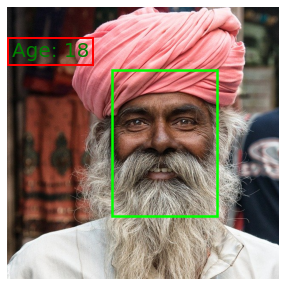

[INFO] computing face detections...
tf.Tensor(
[[0.00584631 0.00659903 0.01259095 0.02324032 0.02729804 0.02754327
  0.03157804 0.01561332 0.00915434 0.02009186 0.02836165 0.01151275
  0.01027765 0.0131168  0.01418778 0.01990973 0.02601773 0.06053512
  0.06938717 0.0546617  0.04910319 0.00812949 0.01554754 0.0201193
  0.0066315  0.06348979 0.01164539 0.01430746 0.01664034 0.01869821
  0.01777158 0.01347556 0.01809421 0.05266542 0.02913495 0.01056318
  0.00866412 0.00351923 0.00390915 0.01271565 0.00773747 0.00439197
  0.00656955 0.00488154 0.00364169 0.00596133 0.00532472 0.00297871
  0.00289861 0.00325896 0.00628968 0.00318517 0.00396203 0.00320521
  0.00548294 0.00474859 0.00278249 0.00433588 0.00155965 0.00370914
  0.0010364  0.00464746 0.00719842 0.00227061 0.00225383 0.0024128
  0.00274362 0.00295992 0.00195206 0.00327072]], shape=(1, 70), dtype=float32)


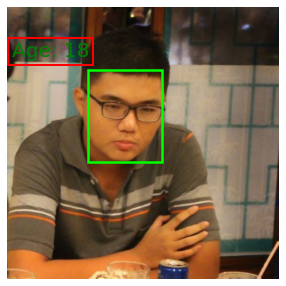

[INFO] computing face detections...
tf.Tensor(
[[0.30002618 0.03864066 0.04983976 0.03933747 0.14831233 0.03835721
  0.02614881 0.02510992 0.00801173 0.00485108 0.01351204 0.0103664
  0.00312854 0.00631827 0.00318052 0.00815073 0.00789341 0.03491206
  0.01859492 0.01007207 0.00698829 0.00136707 0.00926867 0.00206194
  0.00564771 0.01751109 0.00869668 0.0094378  0.00316882 0.0095898
  0.01043287 0.00401911 0.00381014 0.01297584 0.0042567  0.00812124
  0.00799463 0.00176961 0.00136902 0.00552914 0.01460401 0.00273272
  0.00576878 0.00266919 0.00289909 0.00184966 0.00134571 0.00151506
  0.00185513 0.00323864 0.00400716 0.00164234 0.00338484 0.00277564
  0.00138891 0.00244238 0.00217421 0.00073552 0.0008396  0.00281667
  0.00045452 0.00187233 0.00093476 0.0010348  0.00137023 0.00102122
  0.00067735 0.00082594 0.00088803 0.00145537]], shape=(1, 70), dtype=float32)


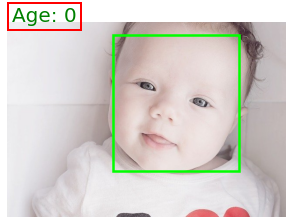

[INFO] computing face detections...
tf.Tensor(
[[0.00834104 0.01786369 0.07988888 0.13717456 0.14682266 0.03371514
  0.08974669 0.02496976 0.00900309 0.02055681 0.02592352 0.02072557
  0.01083701 0.01596231 0.00940938 0.0056976  0.02441414 0.04488145
  0.02321873 0.01629313 0.03967033 0.00319582 0.01608046 0.00316489
  0.0070065  0.01936143 0.00749877 0.00573649 0.00241027 0.00848083
  0.01565505 0.004883   0.00648225 0.01102729 0.00508101 0.00419012
  0.00662574 0.00238665 0.00203745 0.00325033 0.00404571 0.00265333
  0.00350468 0.0023873  0.0014602  0.0045689  0.00108822 0.00103653
  0.00130204 0.00459317 0.00276359 0.00262163 0.00213986 0.00247006
  0.00133886 0.00251048 0.00143029 0.00128521 0.00100561 0.00352523
  0.00055733 0.00160601 0.00126315 0.0014943  0.00116361 0.00115388
  0.00112212 0.00142898 0.00107913 0.0017307 ]], shape=(1, 70), dtype=float32)


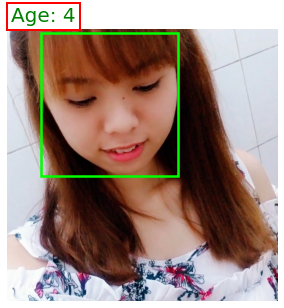

In [11]:
import numpy as np
import matplotlib as mp
from google.colab import files
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/drive/My Drive/WORKSPACE/HK192/AI/AI_COLAB/FG-NET/' + fn
  image = cv2.imread(path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # image = cv2.resize(image, (1024, 1024))
  (h, w) = image.shape[:2]
  blob = cv2.dnn.blobFromImage(image, 1.0, (224, 224),(104.0, 177.0, 123.0))

  # pass the blob through the network and obtain the face detections
  print("[INFO] computing face detections...")
  faceNet.setInput(blob)
  detections = faceNet.forward()

  rects = []
  # loop over the detections
  for i in range(0, detections.shape[2]):
    # extract the confidence (i.e., probability) associated with the
    # prediction
    confidence = detections[0, 0, i, 2]
    # filter out weak detections by ensuring the confidence is
    # greater than the minimum confidence
    if confidence > 0.6:
      # compute the (x, y)-coordinates of the bounding box for the
      # object
      box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
      (startX, startY, endX, endY) = box.astype("int")
      # extract the ROI of the face and then construct a blob from
      # *only* the face ROI
      face = image[startY:endY, startX:endX]

      test_image = face.astype('float') /255.0
      test_image = cv2.resize(test_image, (224, 224))
      test_image = tf.constant(test_image, dtype = 'float32')
      test_image = tf.expand_dims(test_image, axis = 0)
      model = load_model('FGNET/images/Age_Model.h5')
      probs = model(test_image)
      print(probs)
      prediction = tf.argmax(probs, axis = 1, output_type=tf.int32)

      age_pred = int(prediction.numpy())

  mp.pyplot.figure(figsize = (5,5))
  rect = mp.pyplot.Rectangle((startX, startY), endX - startX, endY - startY , fill=False, edgecolor= (0, 1, 0), linewidth=2.5)
  mp.pyplot.gca().add_patch(rect)
  mp.pyplot.text(10, startY - 30 , 'Age: {}'.format(age_pred), color = 'green', fontsize = 20, bbox=dict(fill=False, edgecolor='red', linewidth=2))
  mp.pyplot.imshow(image)
  mp.pyplot.axis('Off')
  mp.pyplot.show()

# **Age estimation in real-time**

## **Reference**



*  [Mean-Variance Loss for Deep Age Estimation from a Face](http://openaccess.thecvf.com/content_cvpr_2018/papers/Pan_Mean-Variance_Loss_for_CVPR_2018_paper.pdf)

*   [https://www.tensorflow.org/api_docs/python/tf](https://www.tensorflow.org/api_docs/python/tf)


*   [https://keras.io/api/](https://keras.io/api/)


*   [https://www.pyimagesearch.com/2020/04/13/opencv-age-detection-with-deep-learning/](https://www.pyimagesearch.com/2020/04/13/opencv-age-detection-with-deep-learning/)



